# CONFIGURACION DE ENTORNO

**IMPORTANTE**: El siguiente código elimina algunas versiones actuales de librerías que vienen por defecto en el entorno de Colab para instalar otras anteriores necesarias para la ejecución. Para que ese cambio funcione se debe reiniciar el entorno. Simplemente se debe aceptar el mensaje que sale en pantalla y apretar "ejecutar todo" nuevamente.

Si es la primera vez que ejecutas el código, ten en cuenta que el código que genera la base de datos de Neo4j está comentado. Esto para evitar inserciones erróneas si la misma ya está creada. Se recomienda bajar a la celda *Base de datos de grafos* y descomentarla para que se ejecute correctamente al correr todo.

In [ ]:
# 1. Desinstalamos versiones previas que puedan estar cargadas en memoria
!pip uninstall -y google-generativeai langgraph langchain langchain-community

# 2. Instalamos TODO nuevamente con las versiones exactas pedidas
!pip install -U \
    langchain==0.3.0 \
    langchain-community==0.3.0 \
    langgraph==0.2.20 \
    langchain-google-genai \
    google-generativeai \
    langchain-chroma \
    langchain-huggingface \
    rank_bm25 \
    flashrank \
    sentence-transformers \
    pandas \
    matplotlib

Found existing installation: google-generativeai 0.8.5
Uninstalling google-generativeai-0.8.5:
  Successfully uninstalled google-generativeai-0.8.5
Found existing installation: langgraph 1.0.3
Uninstalling langgraph-1.0.3:
  Successfully uninstalled langgraph-1.0.3
Found existing installation: langchain 1.1.0
Uninstalling langchain-1.1.0:
  Successfully uninstalled langchain-1.1.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of langchain-google-genai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This

# Descarga de datos

In [ ]:
import gdown
import os
from torch.cuda import is_available

In [ ]:
# Utilizar gpu si está disponible en el entorno
device = "cuda" if is_available() else "cpu"
device

'cuda'

In [ ]:
# ID del archivo
id_archivo = "1gqpBU-6jr1qbBBrUeDXELxV4V51R5V2L"

# Definir nombre de salida
output_file = "archivo_descargado.zip"

# Descargar usando el ID
# La opción 'fuzzy=True' ayuda a gdown a encontrar el archivo mejor
url = f'https://drive.google.com/uc?id={id_archivo}'
gdown.download(url, output_file, quiet=False)

# Descomprimir
print("Descomprimiendo...")
!unzip -o {output_file} -d /content

# Borrar el zip para ahorrar espacio
if os.path.exists(output_file):
    os.remove(output_file)

print("✅ ¡Listo! Archivos disponibles en la carpeta 'fuentes_de_informacion'")

Downloading...
From: https://drive.google.com/uc?id=1gqpBU-6jr1qbBBrUeDXELxV4V51R5V2L
To: /content/archivo_descargado.zip
100%|██████████| 3.81M/3.81M [00:00<00:00, 134MB/s]


Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: /content/fuentes_de_informacion/resenas_usuarios/resena_R03527.txt  
  inflating: /content/fuentes_de_informacion/resenas_usuarios/resena_R02558.txt  
  inflating: /content/fuentes_de_informacion/faqs.json  
  inflating: /content/fuentes_de_informacion/resenas_usuarios/resena_R04816.txt  
  inflating: /content/fuentes_de_informacion/resenas_usuarios/resena_R04926.txt  
  inflating: /content/fuentes_de_informacion/resenas_usuarios/resena_R02810.txt  
  inflating: /content/fuentes_de_informacion/resenas_usuarios/resena_R04787.txt  
  inflating: /content/fuentes_de_informacion/resenas_usuarios/resena_R04748.txt  
  inflating: /content/fuentes_de_informacion/resenas_usuarios/resena_R02588.txt  
  inflating: /content/fuentes_de_informacion/resenas_usuarios/resena_R04040.txt  
  inflating: /content/fuentes_de_informacion/resenas_usuarios/resena_R02304.txt  
  inflating: /content/fuentes_de_informacion/resenas_usu

# Gemini API

### Importación de la librería

In [ ]:
import google.generativeai as genai

### API Key de Google

Anteriormente se debe generar una API Key en https://aistudio.google.com/app/api-keys.

In [ ]:
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GeminiAPI')

genai.configure(api_key=GOOGLE_API_KEY)

### Inicialización el modelo

El modelo seleccionado para la realización del trabajo será gemini-2.5-flash-lite. El mismo ofrece un gran balance entre rendimiento y costo, permitiendo realizar una gran cantidad de llamadas a la API sin tener problemas. Se explica con más detalle las capacidades del modelo y la decisión tomada en el informe.

In [ ]:
# Selección de modelo
llm = genai.GenerativeModel('models/gemini-2.5-flash')

# ETL

## Base de datos tabular

In [ ]:
import pandas as pd
import json
import numpy as np

In [ ]:
productos = pd.read_csv('/content/fuentes_de_informacion/productos.csv')
inventario = pd.read_csv('/content/fuentes_de_informacion/inventario_sucursales.csv')
tickets = pd.read_csv('/content/fuentes_de_informacion/tickets_soporte.csv')
vendedores = pd.read_csv('/content/fuentes_de_informacion/vendedores.csv')
ventas = pd.read_csv('/content/fuentes_de_informacion/ventas_historicas.csv')
devoluciones = pd.read_csv('/content/fuentes_de_informacion/ventas_historicas.csv')

Analizar_dataframes observará todos los dataframes con los que se cuenta para extraer información sobre su estructura, los tipos de datos y las columnas de cada uno. La salida se utilizará luego para que un LLM pueda generar consultas de manera automática con la mayor precisión posible.

In [ ]:
def analizar_dataframes(diccionario_dataframes: dict) -> dict:
    """
    Extrae información sobre dataframes de pandas para
    que modelos de lenguaje puedan generar consultas de manera automática
    """
    schema_simplificado = {}

    for nombre_df, df in diccionario_dataframes.items():
        columnas_info = []

        for col in df.columns:
            dtype = str(df[col].dtype)
            if "int" in dtype: tipo = "int"
            elif "float" in dtype: tipo = "float"
            elif "object" in dtype or "category" in dtype: tipo = "str"
            elif "date" in dtype: tipo = "date"
            elif "bool" in dtype: tipo = "bool"
            else: tipo = "obj"

            columnas_info.append(f"{col}({tipo})")

        # Formato limpio: lista plana de strings
        schema_simplificado[nombre_df] = columnas_info

    return schema_simplificado

In [ ]:
# Carga de archivos en diccionario
mis_dataframes = {
    "vendedores": vendedores,
    "ventas": ventas,
    "inventario": inventario,
    "productos": productos,
    "tickets": tickets,
    "devoluciones": devoluciones
}

# Ejecutar el análisis
info_para_llm = analizar_dataframes(mis_dataframes)

# Como se ve la salida
print(json.dumps(info_para_llm, indent=2, ensure_ascii=False))

{
  "vendedores": [
    "id_vendedor(str)",
    "nombre(str)",
    "apellido(str)",
    "email(str)",
    "telefono(str)",
    "sucursal(str)",
    "fecha_ingreso(str)",
    "nivel(str)",
    "comision_pct(float)",
    "activo(bool)"
  ],
  "ventas": [
    "id_venta(str)",
    "fecha(str)",
    "hora(str)",
    "id_producto(str)",
    "nombre_producto(str)",
    "id_vendedor(str)",
    "nombre_vendedor(str)",
    "sucursal(str)",
    "cantidad(int)",
    "precio_unitario(float)",
    "descuento_pct(int)",
    "total(float)",
    "metodo_pago(str)",
    "cliente_nombre(str)",
    "cliente_provincia(str)"
  ],
  "inventario": [
    "id_inventario(str)",
    "sucursal(str)",
    "id_producto(str)",
    "nombre_producto(str)",
    "categoria(str)",
    "marca(str)",
    "stock_sucursal(int)",
    "stock_minimo(int)",
    "stock_maximo(int)",
    "precio_sucursal(float)",
    "ultima_reposicion(str)",
    "proveedor(str)",
    "pasillo(str)",
    "estado(str)"
  ],
  "productos": [
    "id_

La siguiente función utiliza la información extraída previamente sobre los metadatos de todos los dataframe disponibles como contexto para el LLM. El mismo tomará la pregunta del usuario y la convertirá en un código de filtrado de pandas, decidiendo de manera propia sobre que dataframe debe hacer la consulta. La función devolverá las filas que se hayan conseguido una vez aplicado el filtrado.

In [ ]:
def table_search(consulta, metadatos, diccionario_dataframes, model):
    """
    Genera y ejecuta código Pandas.
    CORRECCIÓN: Distingue mejor entre 'cantidad de unidades' y 'total monetario'.
    """

    nombres_validos = list(diccionario_dataframes.keys())
    contexto_metadatos = json.dumps(metadatos, indent=2, ensure_ascii=False)

    prompt = f"""
    Eres un Data Scientist experto en Python y Pandas.
    Tu tarea es generar UNA ÚNICA EXPRESIÓN de Pandas para responder la consulta.

    --- TABLAS DISPONIBLES ---
    {nombres_validos}
    --------------------------

    CONTEXTO DE DATOS:
    {contexto_metadatos}

    INSTRUCCIONES DE LÓGICA DE NEGOCIO (CRÍTICO):
    1. **"¿Cuántos [productos] se vendieron?"**:
       - Debes sumar la columna 'cantidad'.
       - BIEN: `df[filtro]['cantidad'].sum()`
       - MAL: `df[filtro].shape[0]` (Esto cuenta tickets, no productos)
       - MAL: `df[filtro]['total'].sum()` (Esto es dinero, no cantidad)

    2. **"¿Cuánto se vendió / facturó / ingresó?"**:
       - Debes sumar la columna 'total'.
       - BIEN: `df[filtro]['total'].sum()`

    INSTRUCCIONES TÉCNICAS:
    1. Usa SIEMPRE la variable `df`.
    2. Columna 'fecha' ya es datetime.
    3. Devuelve JSON con "codigo" en una sola línea.

    EJEMPLOS:
    - User: "¿Cuántas licuadoras se vendieron?" -> {{ "nombre_dataframe": "ventas", "codigo": "df[df['nombre_producto'].str.contains('Licuadora', case=False)]['cantidad'].sum()" }}
    - User: "¿Cuánto dinero generaron las licuadoras?" -> {{ "nombre_dataframe": "ventas", "codigo": "df[df['nombre_producto'].str.contains('Licuadora', case=False)]['total'].sum()" }}
    - User: "Ventas de 2025" -> {{ "nombre_dataframe": "ventas", "codigo": "df[df['fecha'].dt.year == 2025]['cantidad'].sum()" }}

    CONSULTA: "{consulta}"
    """

    try:
        response = model.generate_content(prompt, generation_config=genai.types.GenerationConfig(temperature=0.0))
        texto_limpio = response.text.replace("```json", "").replace("```", "").strip()
        instrucciones = json.loads(texto_limpio)
        nombre_df = instrucciones.get('nombre_dataframe')
        contenido_respuesta = instrucciones.get('codigo')

        if nombre_df == "MENSAJE": return contenido_respuesta
        if nombre_df not in diccionario_dataframes: return "Error técnico: Tabla no encontrada."

        # print(f"   --> Query Pandas: {contenido_respuesta}") # Debug opcional

        df = diccionario_dataframes[nombre_df].copy()
        if 'fecha' in df.columns:
            try: df['fecha'] = pd.to_datetime(df['fecha'])
            except: pass

        if contenido_respuesta.startswith("df ="): contenido_respuesta = contenido_respuesta.split("=", 1)[1].strip()

        resultado = eval(contenido_respuesta, {"pd": pd}, {"df": df})
        return resultado

    except Exception as e:
        return f"Error Pandas: {str(e)}"

Se realizan diversas pruebas para realizar un testeo del sistema de filtrado automático.

In [ ]:
print("--- PRUEBA DE CONSULTA ---")
df_resultado = table_search(
    "¿Qué productos son de la marca ChefMaster?",
    info_para_llm,    # Metadatos extraídos
    mis_dataframes,   # Diccionario con los DataFrames reales
    llm               # Modelo
)

# Mostrar resultado si es un DataFrame
if isinstance(df_resultado, pd.DataFrame):
    print(f"\nFilas encontradas: {len(df_resultado)}")
    display(df_resultado.head())
else:
    print(df_resultado)

print("--- PRUEBA DE CONSULTA 2 ---")
df_resultado2 = table_search(
    "¿Cuantas devoluciones hubo en total en el año 2025?",
    info_para_llm,
    mis_dataframes,
    llm
)

# Mostrar resultado si es un DataFrame
if isinstance(df_resultado2, pd.DataFrame):
    print(f"\nFilas encontradas: {len(df_resultado2)}")
    display(df_resultado2.head())
else:
    print(df_resultado2)

--- PRUEBA DE CONSULTA ---
3                       Compacto Licuadora
5                                Licuadora
18                        Batidora de Mano
26                               Mixer Pro
28        Compacto Rallador Eléctrico 2024
31                        Abridor de Latas
39                   Molinillo de Café Pro
51                 Deluxe Freidora de Aire
63                        Sandwichera 3000
65                             Pro Waflera
66                                 Waflera
68                                 Waflera
72     Profesional Parrilla Eléctrica 3000
77               Profesional Olla Arrocera
80                      Olla Arrocera Plus
85           Digital Olla de Cocción Lenta
90                       Advanced Heladera
92                                Heladera
94                           Plus Heladera
99                        Pro Freezer Plus
103                    Eco Conservadora II
117                           Pro Vinoteca
121                        

## Base de datos vectorial

### Carga de modelo de embedding

Para el modelo de embedding se usa "intfloat/multilingual-e5-base", que en terminos de potencia está entre medio de la misma versión small y large del mismo modelo. Se expresan sus capacidades con mayor detalle en el informe.

In [ ]:
import glob
import re
import json
import shutil
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter,MarkdownHeaderTextSplitter
from langchain_core.documents import Document
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
# Rutas de las carpetas
PATH_MANUALES = '/content/fuentes_de_informacion/manuales_productos'
PATH_RESENAS = '/content/fuentes_de_informacion/resenas_usuarios'
PATH_FAQS_ARCHIVO = '/content/fuentes_de_informacion/faqs.json'

# Modelo de Embedding
MODEL_NAME = "intfloat/multilingual-e5-base"

Se intenta descargar en la siguiente celda un backup de la base de datos guardada en Drive. Si falla la descarga de la base, el código la generará de cero.

In [ ]:
# --- CONFIGURACIÓN ---
ID_VECTOR_DB_BACKUP = "1KYHhbfux1WexhnPrRMAbl95ibSsEy9kl"
DB_PATH = "/content/vector_db"
ZIP_NAME = "vector_db_download.zip"

# Bandera de control
db_cargada_con_exito = False

# 1. Configurar Modelo de Embeddings
print(f"Cargando modelo de embeddings ({MODEL_NAME})...")
embeddings = HuggingFaceEmbeddings(
    model_name=MODEL_NAME,
    model_kwargs={'device': device},
    encode_kwargs={'normalize_embeddings': True}
)


try:
    print(f"\n⬇Intentando descargar Vector DB desde Drive...")

    # 1. Limpieza previa: Si la carpeta vector_db ya existe, la borramos para empezar limpio
    if os.path.exists(DB_PATH):
        shutil.rmtree(DB_PATH)

    # 2. Descargar
    url = f'https://drive.google.com/uc?id={ID_VECTOR_DB_BACKUP}'
    output = gdown.download(url, ZIP_NAME, quiet=False)

    if output:
        print("Descomprimiendo en carpeta destino...")

        # Creamos la carpeta destino explícitamente
        os.makedirs(DB_PATH, exist_ok=True)

        # Descomprimimos DENTRO de esa carpeta (-d DB_PATH)
        # Usamos -o para sobreescribir sin preguntar
        !unzip -o -q {ZIP_NAME} -d {DB_PATH}

        # Verificar si la estructura es correcta
        if os.path.exists(os.path.join(DB_PATH, "chroma.sqlite3")):
            print("Conectando a ChromaDB restaurada...")
            vector_db = Chroma(
                persist_directory=DB_PATH,
                embedding_function=embeddings,
                collection_name="electrodomesticos_db"
            )


            print(f"¡ÉXITO! Base cargada")
            db_cargada_con_exito = True
        else:
            print("El ZIP no tenía la estructura esperada de ChromaDB.")
    else:
        print("No se pudo descargar el archivo (gdown falló).")

except Exception as e:
    print(f"Falló la carga desde Drive: {e}")
    db_cargada_con_exito = False

# Limpieza del zip
if os.path.exists(ZIP_NAME):
    os.remove(ZIP_NAME)

Cargando modelo de embeddings (intfloat/multilingual-e5-base)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]


⬇Intentando descargar Vector DB desde Drive...


Downloading...
From (original): https://drive.google.com/uc?id=1KYHhbfux1WexhnPrRMAbl95ibSsEy9kl
From (redirected): https://drive.google.com/uc?id=1KYHhbfux1WexhnPrRMAbl95ibSsEy9kl&confirm=t&uuid=68bdb825-0e32-4bd4-bce4-bc5bb870b869
To: /content/vector_db_download.zip
100%|██████████| 35.0M/35.0M [00:00<00:00, 120MB/s]


Descomprimiendo en carpeta destino...
Conectando a ChromaDB restaurada...


/tmp/ipython-input-53572250.py:43: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_db = Chroma(


¡ÉXITO! Base cargada


### Procesado de documentos

Creación de chunks para la base vectorial.

In [ ]:
def cargar_y_procesar_documentos_hibrido():
    todos_los_fragmentos = []


    # Splitter recursivo
    text_splitter_general = RecursiveCharacterTextSplitter(
        chunk_size=2000,
        chunk_overlap=200,
        separators=["\n\n", "\n", ". ", " ", ""]
    )

    # Splitter Markdown
    # Definimos qué encabezados queremos usar para cortar
    headers_to_split_on = [
        ("#", "titulo_principal"),
        ("##", "seccion"),
        ("###", "subseccion"),
    ]
    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)

    # Manuales
    archivos_manuales = glob.glob(os.path.join(PATH_MANUALES, "*.md"))
    print(f"Procesando {len(archivos_manuales)} manuales con Markdown Splitter...")

    for ruta in archivos_manuales:
        nombre_archivo = os.path.basename(ruta)
        with open(ruta, 'r', encoding='utf-8') as f:
            contenido = f.read()

            # Extracción de Metadatos Globales
            # Estos metadatos aplican a TODO el documento
            modelo_match = re.search(r"Modelo[:\*\s]+(P\d+)", contenido, re.IGNORECASE)
            categoria_match = re.search(r"Categoría[:\*\s]+([^\n]+)", contenido, re.IGNORECASE)
            nombre_match = re.search(r"Nombre Comercial[:\*\s]+([^\n]+)", contenido, re.IGNORECASE)

            modelo_final = modelo_match.group(1) if modelo_match else "desconocido"
            if modelo_final == "desconocido":
                match_filename = re.search(r"(P\d+)", nombre_archivo)
                if match_filename: modelo_final = match_filename.group(1)

            categoria_final = categoria_match.group(1).replace('*', '').strip() if categoria_match else "general"
            nombre_final = nombre_match.group(1).replace('*', '').strip() if nombre_match else "desconocido"

            metadata_global = {
                "source": nombre_archivo,
                "tipo": "manual",
                "modelo": modelo_final,
                "categoria": categoria_final,
                "nombre": nombre_final,
            }

            # Split de markdown
            docs_md = markdown_splitter.split_text(contenido)

            for doc in docs_md:
                # Fusionamos metadata global con la metadata del header
                doc.metadata.update(metadata_global)

                # Si una sección del manual es GIGANTE (>2000 chars),
                # la cortamos con el recursivo para que entre en el modelo.
                # Si es pequeña, el recursivo no hará nada y la dejará igual.
                sub_chunks = text_splitter_general.split_documents([doc])

                todos_los_fragmentos.extend(sub_chunks)

    # Reseñas
    archivos_resenas = glob.glob(os.path.join(PATH_RESENAS, "*.txt"))
    print(f"Procesando {len(archivos_resenas)} reseñas...")

    for ruta in archivos_resenas:
        with open(ruta, 'r', encoding='utf-8') as f:
            contenido = f.read()

            producto_match = re.search(r"Producto:\s*(.+?)(?:\(P\d+\)|$)", contenido)
            puntaje_match = re.search(r"Puntaje:\s*(\d+)/5", contenido)

            metadata = {
                "source": os.path.basename(ruta),
                "tipo": "resena",
                "producto": producto_match.group(1).strip() if producto_match else "desconocido",
                "puntaje": int(puntaje_match.group(1)) if puntaje_match else 0
            }

            # Creamos doc y fragmentamos
            doc_obj = Document(page_content=contenido, metadata=metadata)
            chunks = text_splitter_general.split_documents([doc_obj])
            todos_los_fragmentos.extend(chunks)

    return todos_los_fragmentos

# --- EJECUCIÓN ---
print("Iniciando carga híbrida...")
docs_fragmentados = cargar_y_procesar_documentos_hibrido()

print(f"\n✅ Total de fragmentos finales generados: {len(docs_fragmentados)}")

# --- VERIFICACIÓN VISUAL ---
if len(docs_fragmentados) > 0:
    # Buscamos un fragmento de manual para ver cómo quedó la metadata de Markdown
    ejemplo_manual = next((d for d in docs_fragmentados if d.metadata['tipo'] == 'manual'), None)

    if ejemplo_manual:
        print("\n--- Ejemplo de Fragmento de Manual (Markdown Splitter) ---")
        print(f"METADATA: {ejemplo_manual.metadata}")

Iniciando carga híbrida...
Procesando 50 manuales con Markdown Splitter...
Procesando 5015 reseñas...

✅ Total de fragmentos finales generados: 6029

--- Ejemplo de Fragmento de Manual (Markdown Splitter) ---
METADATA: {'titulo_principal': 'Manual Técnico - Olla Arrocera 3000', 'source': 'manual_P0082_Olla_Arrocera_3000.md', 'tipo': 'manual', 'modelo': 'P0082', 'categoria': 'Cocina - Cocción', 'nombre': 'Olla Arrocera 3000'}


### Embedding y Chroma DB

En el caso del fallo de la descarga del backup, se crea la base vectorial, introduciendo la información en tandas para no superar el límite de Chroma.

In [ ]:
from tqdm import tqdm
import shutil
import os

# Generar base vectorial si no funcionó la descarga
if not db_cargada_con_exito:
    # Limpiar base de datos anterior si existe
    db_path = "/content/vector_db"
    if os.path.exists(db_path):
        print("🗑️  Limpiando base de datos anterior...")
        shutil.rmtree(db_path)

    # Cargar modelo de embedding
    print("Cargando modelo de embeddings...")
    embeddings = HuggingFaceEmbeddings(
        model_name=MODEL_NAME,
        model_kwargs={'device': device}
    )

    print(f"Total de documentos a procesar: {len(docs_fragmentados)}")

    # Crear ChromaDB vacía
    print("Inicializando base de datos vectorial...")
    vector_db = Chroma(
        collection_name="electrodomesticos_db",
        embedding_function=embeddings,
        persist_directory=db_path
    )

    # Configuración de batches
    BATCH_SIZE = 4500
    total_docs = len(docs_fragmentados)
    total_batches = (total_docs + BATCH_SIZE - 1) // BATCH_SIZE

    print(f"Procesando en {total_batches} batches...")

    documentos_insertados = 0

    # Procesar con barra de progreso y manejo de errores
    for i in tqdm(range(0, total_docs, BATCH_SIZE), desc="Insertando documentos"):
        batch = docs_fragmentados[i:i + BATCH_SIZE]
        batch_num = (i // BATCH_SIZE) + 1

        try:
            vector_db.add_documents(batch)
            documentos_insertados += len(batch)

        except Exception as e:
            print(f"\nError en batch {batch_num}: {str(e)[:100]}")
            print(f"Reintentando con batches más pequeños...")

            # Dividir en sub-batches de 1000
            for j in range(0, len(batch), 1000):
                sub_batch = batch[j:j + 1000]
                try:
                    vector_db.add_documents(sub_batch)
                    documentos_insertados += len(sub_batch)
                except Exception as sub_e:
                    print(f"Error persistente en sub-batch: {sub_e}")
                    # Intentar documento por documento como último recurso
                    for doc in sub_batch:
                        try:
                            vector_db.add_documents([doc])
                            documentos_insertados += 1
                        except:
                            print(f"Documento individual falló, saltando...")

    # Persistir
    print("\nPersistiendo base de datos...")
    vector_db.persist()

    # Verificación final
    docs_en_db = vector_db._collection.count()
    print(f"\n{'='*60}")
    print(f"✅ RESUMEN:")
    print(f"Documentos originales: {total_docs}")
    print(f"Documentos insertados: {documentos_insertados}")
    print(f"Documentos en DB: {docs_en_db}")
    print(f"Ubicación: {db_path}")
    print(f"{'='*60}")

    if docs_en_db < total_docs * 0.95:  # Si falta más del 5%
        print("ADVERTENCIA: Algunos documentos no se insertaron correctamente")
    else:
        print("Base de datos creada exitosamente!")

### Test de funcionamiento del embedding

In [ ]:
def buscar_informacion(query, k=5, filtro=None):
    """
    Busca fragmentos relevantes en la base de datos vectorial.

    Args:
        query (str): La pregunta del usuario.
        k (int): Cantidad de fragmentos a recuperar.
        filtro (dict, optional): Filtros de metadatos. Ej: {'tipo': 'manual'}
                                 o {'modelo': 'P0004'}

    Returns:
        list: Lista de documentos recuperados.
    """

    # Realizar búsqueda de similitud
    resultados = vector_db.similarity_search(
        query,
        k=k,
        filter=filtro # filtro de metadatos de Chroma
    )

    return resultados

# Pruebas
print("Prueba 1: Búsqueda General")
print("Pregunta: ¿Cómo hacer un smoothie?")
res = buscar_informacion("¿Cómo hacer un smoothie?", k=2)
for doc in res:
    print(f"[Fuente: {doc.metadata.get('source')}]")
    print(doc.page_content)
    print("-" * 20)

print("\nPrueba 2: Búsqueda de manuales")
print("Query: Problemas de encendido")
res_filtrada = buscar_informacion(
    "problemas de encendido",
    k=2,
)

for doc in res_filtrada:
    print(f"[Modelo detectado: {doc.metadata.get('modelo')}]")
    print(doc.page_content)
    print("-" * 20)

print("\nPRUEBA 3: Búsqueda de reseñas")
print("Pregunta: Es bueno el Exprimidor 2024?")
res_filtrada = buscar_informacion(
    "es bueno el Exprimidor 2024?",
    k=2,
)
for doc in res_filtrada:
    print(f"[Modelo detectado: {doc.metadata.get('modelo')}]")
    print(doc.page_content)
    print("-" * 20)

print("\nPRUEBA 4: Búsqueda de reseñas")
print("Pregunta: Que piensa la gente de la licuadora?")
res_filtrada = buscar_informacion(
    "que piensa la gente de la licuadora?",
    k=2,
)

for doc in res_filtrada:
    print(f"[Modelo detectado: {doc.metadata.get('modelo')}]")
    print(doc.page_content)
    print("-" * 20)

Prueba 1: Búsqueda General
Pregunta: ¿Cómo hacer un smoothie?
[Fuente: manual_P0004_Compacto_Licuadora.md]
**Dificultad:** Fácil | **Tiempo:** 3-5 minutos  
**Pasos:**  
1. Lavar y cortar las frutas en trozos medianos (2-3 cm)
2. Colocar los ingredientes líquidos primero (leche, yogurt, jugo)
3. Agregar las frutas y hielo en la jarra
4. Cerrar la tapa asegurándose del cierre hermético
5. Comenzar en velocidad baja (nivel 1-2) por 10 segundos
6. Aumentar gradualmente a velocidad alta (nivel 4-5)
7. Procesar durante 45-60 segundos hasta textura homogénea
8. Usar función PULSE para romper trozos grandes si es necesario
9. Verificar consistencia y procesar 10-15 seg adicionales si hace falta
10. Apagar y desconectar antes de retirar la jarra
11. Servir inmediatamente para mejor sabor y textura
--------------------
[Fuente: manual_P0013_Procesadora.md]
**Dificultad:** Medio | **Tiempo:** 12-15 minutos  
**Pasos:**  
1. Instalar el gancho amasador en el eje central del bowl
2. Colocar harina

### Visualización con tsne

In [ ]:
import plotly.express as px
from sklearn.manifold import TSNE
import numpy as np

def visualizar_tsne_3d(vector_db):
    # Extraer datos
    datos = vector_db.get(include=['embeddings', 'metadatas', 'documents'])
    embeddings = np.array(datos['embeddings'])
    metadatas = datos['metadatas']
    textos = datos['documents']

    n_samples = len(embeddings)
    if n_samples < 3:
        print("Necesitas al menos 3 documentos para t-SNE en 3D.")
        return

    # Calcular t-SNE en 3D
    # Ajustamos perplejidad dinámicamente para evitar errores con pocos datos
    perp_val = min(30, n_samples - 1)
    print(f"Calculando t-SNE 3D para {n_samples} vectores...")

    tsne = TSNE(n_components=3, verbose=0, perplexity=perp_val, random_state=42, init='pca', learning_rate='auto')
    vecs_3d = tsne.fit_transform(embeddings)

    # Preparar DataFrame
    lista_dicts = []
    for i in range(n_samples):
        meta = metadatas[i]

        preview = textos[i][:60].replace('\n', ' ') + "..."

        if meta.get('tipo') == 'manual':
            etiqueta_bold = f"<b>Manual: {meta.get('modelo', '?')}</b>"
            info_extra = f"<br>Cat: {meta.get('categoria', '-')}"
        elif meta.get('tipo') == 'resena':
            etiqueta_bold = f"<b>Reseña: {meta.get('producto', '?')}</b>"
            info_extra = f"<br>⭐: {meta.get('puntaje', '-')}/5"
        else:
            etiqueta_bold = "<b>Otro</b>"
            info_extra = ""

        # Construimos un string HTML para el tooltip personalizado
        custom_hover = f"{etiqueta_bold}{info_extra}<br><i>'{preview}'</i>"

        lista_dicts.append({
            'x': vecs_3d[i, 0],
            'y': vecs_3d[i, 1],
            'z': vecs_3d[i, 2],
            'Tipo': meta.get('tipo', 'Desconocido'),
            'Tooltip': custom_hover
        })

    df = pd.DataFrame(lista_dicts)

    # Crear Gráfico 3D
    fig = px.scatter_3d(
        df,
        x='x', y='y', z='z',
        color='Tipo',
        custom_data=['Tooltip'],
        title='Distribución Semántica 3D',
        template='plotly_white',
        opacity=0.7
    )

    # Ajustes para que el tooltip sea pequeño y limpio
    fig.update_traces(
        marker=dict(size=5),
        hovertemplate="%{customdata[0]}<extra></extra>"
    )

    fig.update_layout(
        margin=dict(l=0, r=0, b=0, t=40), # Márgenes mínimos para aprovechar espacio
        height=700,
        scene=dict(
            xaxis_title='Dim 1',
            yaxis_title='Dim 2',
            zaxis_title='Dim 3'
        )
    )

    fig.show()

visualizar_tsne_3d(vector_db)

Calculando t-SNE 3D para 6029 vectores...


## Base de datos de grafos

In [ ]:
!pip install -q neo4j

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.4/325.4 kB 5.9 MB/s eta 0:00:00


Para poder ejecutar la base de datos de grafos Neo4j, se necesita registrarse y generar una instancia de base de datos en la siguiente página: [https://console.neo4j.io/](https://console.neo4j.io/). Generar la instancia nos dará acceso a una contraseña y a un usuario que se recomiendan guardar como secreto en colab para accederlo de manera segura a través del código, aunque simplemente se pueden copiar en una variable (no es recomendable). Considere que para que el código funcione de manera automática (en caso de haber decidido no copiar las credenciales en el Colab), los nombres de los secretos de colab que se creen deben coincidir con los que están guardados en las variables NEO4J_URI y NEO4J_PASSWORD de la celda de abajo.

In [ ]:
import json
import time
from neo4j import GraphDatabase
import glob

# --- CONFIGURACIÓN ---
NEO4J_URI = userdata.get("Neo4j_uri")
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = userdata.get("Neo4j_password")
PATH_MANUALES = '/content/fuentes_de_informacion/manuales_productos'

# Inicializar driver de Neo4j
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

El código está comentado porque genera la base de datos vectorial en Neo4j, lo cual es un proceso bastante lento. Si no se creó la base todavía se debe descomentar y ejecutar una sola vez. La base de datos estará ligada al ususario y la cuenta que se haya creado anteriormente.  

In [ ]:
import glob
import os
import json
import time
import google.generativeai as genai

# --- FUNCIÓN DE LIMPIEZA ---
def limpiar_json_gemini(texto_respuesta):
    return texto_respuesta.replace("```json", "").replace("```", "").strip()

# --- EXTRACCIÓN CON DEBUG ---
def extraer_grafo_con_gemini(texto_manual, model):
    print(f"    ⏳ [LLM] Enviando {len(texto_manual)} caracteres a Gemini...", end="", flush=True)
    start_t = time.time()

    prompt_original = f"""
    Eres un Ingeniero de Datos Senior experto en extracción de información técnica (ETL) para Neo4j.
    TU OBJETIVO: Extraer TODAS las entidades y relaciones del manual técnico proporcionado.

    CRITICIDAD:
    1. EXHAUSTIVIDAD: Si hay una tabla de "Componentes" o "Piezas", debes extraer CADA UNO de los ítems.
    2. INFERENCIA: Si el manual no tiene lista de partes, infiere los componentes leyendo los procedimientos.

    TEXTO DEL MANUAL:
    {texto_manual}

    --- SCHEMA A RESPETAR ---
    NODOS:
    - Producto {{id: "Pxxxx", nombre: "...", categoria: "...", marca: "..."}}
    - Componente {{nombre: "..."}}
    - Procedimiento {{nombre: "..."}}

    RELACIONES:
    - (Producto)-[:TIENE_COMPONENTE]->(Componente)
    - (Producto)-[:COMPATIBLE_CON]->(Producto)
    - (Producto)-[:COMPARTE_REPUESTO {{tipo: "..."}}]->(Producto)
    - (Componente)-[:USADO_EN]->(Producto)
    - (Producto)-[:TIENE_PROCEDIMIENTO]->(Procedimiento)

    --- REGLAS DE JSON ---
    1. Devuelve un objeto JSON con dos listas: "nodos" y "relaciones".
    2. ENLACE DE RELACIONES: Usa 'id' para Producto y 'nombre' para Componente/Procedimiento.

    Ejemplo de formato EXACTO:
    {{
      "nodos": [
        {{ "tipo": "Producto", "propiedades": {{ "id": "P0004", "nombre": "Licuadora X", "categoria": "Cocina" }} }},
        {{ "tipo": "Componente", "propiedades": {{ "nombre": "Motor 600W", "tipo": "Motor", "especificacion": "Cobre" }} }}
      ],
      "relaciones": [
        {{
           "origen": {{ "propiedad": "id", "valor": "P0004" }},
           "destino": {{ "propiedad": "nombre", "valor": "Motor 600W" }},
           "tipo": "TIENE_COMPONENTE"
        }}
      ]
    }}
    """

    prompt_retry = f"""
    ATENCIÓN: Tu intento anterior falló por generar un JSON inválido.
    TU TAREA ÚNICA: Convertir la información clave del siguiente manual a JSON válido para Neo4j.

    TEXTO:
    {texto_manual}

    Estructura JSON obligatoria:
    {{
      "nodos": [ {{ "tipo": "...", "propiedades": {{...}} }} ],
      "relaciones": [ {{ "origen": {{...}}, "destino": {{...}}, "tipo": "..." }} ]
    }}
    NO agregues texto antes ni después del JSON. Solo el JSON puro.
    """

    try:
        # INTENTO 1
        response = model.generate_content(
            prompt_original,
            generation_config=genai.types.GenerationConfig(temperature=0.1)
        )
        print(f" ✅ Recibido ({time.time()-start_t:.1f}s)")
        return json.loads(limpiar_json_gemini(response.text))

    except Exception as e1:
        print(f"\n    ⚠️ Intento 1 falló ({str(e1)}). Reintentando en 5s...", end="", flush=True)

        try:
            # INTENTO 2
            time.sleep(5)
            response_retry = model.generate_content(
                prompt_retry,
                generation_config=genai.types.GenerationConfig(temperature=0.0)
            )
            datos_recuperados = json.loads(limpiar_json_gemini(response_retry.text))
            print(" ✅ Recuperado.")
            return datos_recuperados

        except Exception as e2:
            print(f" ❌ Error definitivo: {e2}")
            return None

# --- INSERCIÓN CON DEBUG ---
def insertar_en_neo4j(tx, datos_grafo):
    n_nodos = len(datos_grafo.get('nodos', []))
    n_rels = len(datos_grafo.get('relaciones', []))
    print(f"    💾 [Neo4j] Insertando {n_nodos} nodos y {n_rels} relaciones...", end="", flush=True)

    # 1. Nodos
    for nodo in datos_grafo.get('nodos', []):
        props = nodo['propiedades']
        tipo_label = nodo['tipo']

        if tipo_label == "Producto":
            query = "MERGE (p:Producto {id: $id}) ON CREATE SET p.nombre = $nombre, p.categoria = $categoria, p.marca = $marca ON MATCH SET p.nombre = $nombre"
            tx.run(query, id=props.get('id'), nombre=props.get('nombre'), categoria=props.get('categoria', 'General'), marca=props.get('marca', 'Generica'))

        elif tipo_label == "Componente":
            query = "MERGE (c:Componente {nombre: $nombre}) ON CREATE SET c.tipo = $tipo, c.especificacion = $especificacion ON MATCH SET c.tipo = $tipo"
            tx.run(query, nombre=props.get('nombre'), tipo=props.get('tipo', 'General'), especificacion=props.get('especificacion', ''))

        elif tipo_label == "Procedimiento":
            query = "MERGE (proc:Procedimiento {nombre: $nombre}) ON CREATE SET proc.descripcion = $descripcion ON MATCH SET proc.descripcion = $descripcion"
            tx.run(query, nombre=props.get('nombre'), descripcion=props.get('descripcion', ''))

    # 2. Relaciones
    for rel in datos_grafo.get('relaciones', []):
        try:
            tipo_rel = rel['tipo']
            id_origen = rel['origen']['valor']
            val_destino = rel['destino']['valor']

            if tipo_rel == "TIENE_COMPONENTE":
                tx.run("MATCH (p:Producto {id: $o}) MERGE (c:Componente {nombre: $d}) MERGE (p)-[:TIENE_COMPONENTE]->(c)", o=id_origen, d=val_destino)
            elif tipo_rel == "TIENE_PROCEDIMIENTO":
                tx.run("MATCH (p:Producto {id: $o}) MERGE (pr:Procedimiento {nombre: $d}) MERGE (p)-[:TIENE_PROCEDIMIENTO]->(pr)", o=id_origen, d=val_destino)
            elif tipo_rel in ["COMPATIBLE_CON", "COMPARTE_REPUESTO"]:
                tx.run("MERGE (p1:Producto {id: $o}) MERGE (p2:Producto {id: $d}) MERGE (p1)-[r:" + tipo_rel + "]->(p2)", o=id_origen, d=val_destino)
            elif tipo_rel == "USADO_EN":
                tx.run("MERGE (p:Producto {id: $d}) MERGE (c:Componente {nombre: $o}) MERGE (c)-[:USADO_EN]->(p)", o=id_origen, d=val_destino)
        except Exception:
            pass

    print(" ✅ Listo.")

# --- PROCESO PRINCIPAL ---
def procesar_manuales_a_grafo(model):
    archivos = glob.glob(os.path.join(PATH_MANUALES, "*.md"))
    print(f"🚀 Iniciando proceso para {len(archivos)} manuales...")

    conteo_exitos = 0
    conteo_fallos = 0

    for i, archivo in enumerate(archivos):
        nombre = os.path.basename(archivo)
        print(f"\n[{i+1}/{len(archivos)}] Procesando: {nombre}")

        # 1. Leer
        with open(archivo, 'r', encoding='utf-8') as f:
            texto = f.read()

        # 2. Extraer (LLM)
        datos_json = extraer_grafo_con_gemini(texto, model)

        # 3. Insertar (Neo4j)
        if datos_json:
            try:
                with driver.session() as session:
                    session.execute_write(insertar_en_neo4j, datos_json)
                conteo_exitos += 1
            except Exception as e:
                print(f"    ❌ Error conexión Neo4j: {e}")
                conteo_fallos += 1
        else:
            print("    ⚠️ Skip: LLM no devolvió datos.")
            conteo_fallos += 1

        time.sleep(1)

    print(f"\n🏁 Fin. Éxitos: {conteo_exitos} | Fallos: {conteo_fallos}")

# # Ejecutar
# procesar_manuales_a_grafo(llm)

La función Graph Search genera código de Cypher para consultar la base de datos vectorial. Se cuenta con un sistema de reintento en el caso de que la primera  consulta haya dado algún error.

In [ ]:
def graph_search(consulta, model, driver_neo4j):
    """
    Traduce lenguaje natural a Cypher con REINTENTO AUTOMÁTICO si no hay resultados.
    """

    # --- 1. Definición del Esquema ---
    schema_grafo = """
    NODOS:
    - (:Producto {id, nombre, categoria, marca})
    - (:Componente {nombre, tipo, especificacion})
    - (:Procedimiento {nombre, descripcion})

    RELACIONES (Direccionales):
    - (:Producto)-[:TIENE_COMPONENTE]->(:Componente)
    - (:Producto)-[:COMPATIBLE_CON]->(:Producto)
    - (:Producto)-[:COMPARTE_REPUESTO {tipo: "..."}]->(:Producto)
    - (:Componente)-[:USADO_EN]->(:Producto)
    - (:Producto)-[:TIENE_PROCEDIMIENTO]->(:Procedimiento)
    """

    # --- 2. Función Auxiliar para Generar y Limpiar ---
    def generar_cypher(prompt_texto, temperatura=0.2):
        try:
            response = model.generate_content(
                prompt_texto,
                generation_config=genai.types.GenerationConfig(temperature=temperatura)
            )
            texto_limpio = response.text.replace("```json", "").replace("```", "").replace("cypher", "").strip()
            return json.loads(texto_limpio)['query']
        except Exception as e:
            print(f"Error generando Cypher: {e}")
            return None

    # --- 3. PROMPT INTENTO 1 ---
    prompt_inicial = f"""
    Eres un experto en Neo4j. Genera una consulta Cypher para responder al usuario.

    ESQUEMA:
    {schema_grafo}

    REGLAS CRÍTICAS:
    1. NO USES ILIKE. Usa `WHERE toLower(n.prop) CONTAINS toLower('valor')`.
    2. Devuelve JSON con campo "query".

    Consulta: "{consulta}"
    """

    print(f"🕸️ Consultando al Grafo (Intento 1): '{consulta}'...")
    cypher_query = generar_cypher(prompt_inicial, temperatura=0.0)

    if not cypher_query:
        return "Error: No se pudo generar la consulta."

    print(f"   --> Query 1: {cypher_query}")

    # --- 4. Ejecución Intento 1 ---
    resultados = []
    try:
        with driver_neo4j.session() as session:
            result = session.run(cypher_query)
            resultados = [record.data() for record in result]
    except Exception as e:
        print(f"   ⚠️ Error sintaxis Query 1: {e}")
        # Si falla por sintaxis, forzamos reintento inmediato
        resultados = []

    # --- 5. LÓGICA DE REINTENTO (Si está vacío) ---
    if not resultados:
        print("   ⚠️ Sin resultados. Intentando reformulación más amplia...")

        # Prompt de "Recuperación de Error"
        prompt_reintento = f"""
        ACTÚA COMO UN EXPERTO EN DEBUGGING DE NEO4J.

        LA SITUACIÓN:
        El usuario preguntó: "{consulta}"
        Generaste esta query: "{cypher_query}"

        EL PROBLEMA:
        La query devolvió CERO resultados o dio error.

        TU MISIÓN:
        Genera una NUEVA query corregida y más amplia ("Fuzzy Search").

        ESTRATEGIAS DE CORRECCIÓN:
        1. Si buscaste por ID exacto (ej: 'P001'), intenta buscar por NOMBRE usando CONTAINS (ej: 'Licuadora').
        2. Elimina restricciones de relación muy específicas si no estás seguro.
        3. Asegúrate de usar `toLower()` para ignorar mayúsculas.
        4. Si la relación era unidireccional, prueba quitar la flecha de dirección (ej: `(a)-[:REL]-(b)` en vez de `->`).

        ESQUEMA:
        {schema_grafo}

        Responde SOLO con el JSON {{ "query": "..." }}
        """

        # Subimos un poco la temperatura para que sea "creativo" buscando soluciones
        cypher_retry = generar_cypher(prompt_reintento, temperatura=0.3)

        if cypher_retry:
            print(f"   --> Query 2 (Corregida): {cypher_retry}")
            try:
                with driver_neo4j.session() as session:
                    result = session.run(cypher_retry)
                    resultados = [record.data() for record in result]
            except Exception as e:
                return f"Error en reintento: {str(e)}"

    return resultados

In [ ]:
print("--- PRUEBA 1: Componentes ---")
print("Pregunta: Componentes de la licuadora")
res1 = graph_search("Componentes de la licuadora", llm, driver)
print(f"Resultados: {res1}\n")


print("--- PRUEBA 2: Compatibilidad ---")
print("Pregunta: ¿Que productos son compatibles con el ventilador de id P0184?")
res2 = graph_search("¿Que productos son compatibles con el ventilador de id P0184?", llm, driver)
print(f"Resultados: {res2}\n")

print("--- PRUEBA 3: Usos ---")
print("Pregunta: ¿En que producto se usa el motor?")
res3 = graph_search("¿En que producto se usa el motor?", llm, driver)
print(f"Resultados: {res3}\n")
# Pausa para no saturar a la api
time.sleep(30)

--- PRUEBA 1: Componentes ---
Pregunta: Componentes de la licuadora
🕸️ Consultando al Grafo (Intento 1): 'Componentes de la licuadora'...
   --> Query 1: MATCH (p:Producto)-[:TIENE_COMPONENTE]->(c:Componente) WHERE toLower(p.nombre) CONTAINS toLower('licuadora') RETURN c
   ⚠️ Sin resultados. Intentando reformulación más amplia...
   --> Query 2 (Corregida): MATCH (p:Producto)-[:TIENE_COMPONENTE]->(c:Componente) WHERE apoc.text.jaroWinklerSimilarity(toLower(p.nombre), toLower('licuadora')) > 0.8 OR toLower(p.categoria) CONTAINS toLower('licuadora') RETURN c UNION MATCH (c:Componente)-[:USADO_EN]->(p:Producto) WHERE apoc.text.jaroWinklerSimilarity(toLower(p.nombre), toLower('licuadora')) > 0.8 OR toLower(p.categoria) CONTAINS toLower('licuadora') RETURN c
Resultados: Error en reintento: {neo4j_code: Neo.ClientError.Statement.SyntaxError} {message: Unknown function 'apoc.text.jaroWinklerSimilarity' (line 1, column 62 (offset: 61))
"MATCH (p:Producto)-[:TIENE_COMPONENTE]->(c:Componente) W

# Clasificación

Se utilizarán preguntas sintéticas generadas automáticamente para tener información suficiente para entrenar un modelo de clasificación capaz de inferir a que base de datos se le debe realizar una consulta en base a la query del ususario.

## Regresión logística

Se utiliza TF-IDF para probar una alternativa frecuentista a la clasificación, teniendo en cuenta que a continuación se realizará una clasificación que tiene en cuenta la semántica de la query con el LLM.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import time

# Creación de datos sintéticos

datos_fijos = [
    # --- TABULAR (15 ejemplos) ---
    ("¿Cuántas ventas hubo ayer?", "tabular"),
    ("Dime el precio del televisor", "tabular"),
    ("¿Hay stock de la licuadora?", "tabular"),
    ("Total facturado en enero", "tabular"),
    ("Listar vendedores activos", "tabular"),
    ("¿Cuál es el id del producto P004?", "tabular"),
    ("Cantidad de tickets abiertos", "tabular"),
    ("Promedio de ventas por mes", "tabular"),
    ("Muestrame las devoluciones registradas", "tabular"),
    ("Valor máximo de venta", "tabular"),
    ("Precio más alto en la categoría cocinas", "tabular"),
    ("Listar productos que no tienen stock", "tabular"),
    ("Ventas totales del vendedor Juan", "tabular"),
    ("Promedio de precio de los televisores", "tabular"),
    ("Cantidad de clientes registrados en Buenos Aires", "tabular"),

    # --- VECTORIAL (15 ejemplos) ---
    ("¿Qué opinan los usuarios del lavarropas?", "vectorial"),
    ("Busca reseñas sobre la batería", "vectorial"),
    ("¿El manual dice algo de seguridad?", "vectorial"),
    ("Opiniones negativas de la cafetera", "vectorial"),
    ("¿La gente se queja del ruido?", "vectorial"),
    ("Resumen de comentarios positivos", "vectorial"),
    ("¿Qué dice el texto sobre el encendido?", "vectorial"),
    ("Busca en la documentación técnica", "vectorial"),
    ("Experiencias de usuarios con la garantía", "vectorial"),
    ("¿Es ruidoso según las reseñas?", "vectorial"),
    ("¿Qué dicen sobre la duración de la carga?", "vectorial"),
    ("Busca quejas sobre el servicio técnico", "vectorial"),
    ("Resumen de la página 5 del manual", "vectorial"),
    ("Opiniones sobre el diseño del producto", "vectorial"),
    ("¿Mencionan problemas de calentamiento en las reseñas?", "vectorial"),

    # --- GRAFO (15 ejemplos) ---
    ("¿Qué componentes tiene el motor?", "grafo"),
    ("¿El filtro es compatible con la aspiradora?", "grafo"),
    ("Pasos para cambiar el fusible", "grafo"),
    ("Diagrama de conexión del circuito", "grafo"),
    ("¿Qué repuestos necesito para esto?", "grafo"),
    ("Jerarquía de piezas del sistema", "grafo"),
    ("¿En qué productos se usa este cable?", "grafo"),
    ("Despiece técnico de la impresora", "grafo"),
    ("¿Cómo se relaciona la falla con el sensor?", "grafo"),
    ("Árbol de componentes del equipo", "grafo"),
    ("¿Qué motor lleva la aspiradora modelo X?", "grafo"),
    ("Verificar compatibilidad entre cargador y celular", "grafo"),
    ("Pasos para desmontar la cuchilla principal", "grafo"),
    ("¿De qué pieza depende el termostato?", "grafo"),
    ("Listar partes del sistema de refrigeración", "grafo")
]

# Convertir a DataFrame
df = pd.DataFrame(datos_fijos, columns=["query", "target"])

print(f"✅ Datos creados: {len(df)} ejemplos en total.")
print(df['target'].value_counts())

# División Train Test

X = df['query']
y = df['target']

# Separamos: 70% para entrenar, 30% para testear
# stratify=y asegura que haya la misma proporción de clases en ambos grupos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n⚙️ Datos de Entrenamiento: {len(X_train)}")
print(f"⚙️ Datos de Test: {len(X_test)}")

# Entrenamiento

clasificador_propio = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

# Entrenamos
clasificador_propio.fit(X_train, y_train)
print("\n✅ Modelo entrenado exitosamente.")

# Evaluación

print("\n--- REPORTE DE CLASIFICACIÓN (Test Set) ---")
y_pred = clasificador_propio.predict(X_test)
print(classification_report(y_test, y_pred))

✅ Datos creados: 45 ejemplos en total.
target
tabular      15
vectorial    15
grafo        15
Name: count, dtype: int64

⚙️ Datos de Entrenamiento: 36
⚙️ Datos de Test: 9

✅ Modelo entrenado exitosamente.

--- REPORTE DE CLASIFICACIÓN (Test Set) ---
              precision    recall  f1-score   support

       grafo       1.00      0.33      0.50         3
     tabular       0.50      0.67      0.57         3
   vectorial       0.50      0.67      0.57         3

    accuracy                           0.56         9
   macro avg       0.67      0.56      0.55         9
weighted avg       0.67      0.56      0.55         9



## Clasificación con LLM

En el código de abajo se realiza una prueba con nuestros datos sintéticos para comparar el redimiento de ambos clasificadores.

In [ ]:
def clasificador_llm_few_shot_robusto(queries, model):
    """
    Clasifica queries usando Gemini con Few-Shot Prompting.
    Incluye manejo de errores de cuota (429) y caídas de servidor (503).
    """

    # Configuración de Seguridad
    PAUSA_ENTRE_LLAMADAS = 15  # Segundos entre consultas
    PAUSA_POR_CUOTA = 40      # Segundos si sale error 429

    # Prompt Few-Shot
    few_shot_prompt = """
    Eres un experto en clasificación de intenciones para un sistema RAG.
    Tu tarea es clasificar la consulta del usuario en una de estas tres categorías:

    CATEGORÍAS:
    - tabular: Consultas sobre cantidades, precios, stock, fechas, conteos o datos estructurados.
    - vectorial: Consultas sobre opiniones, reseñas, contenido de manuales, texto libre o búsqueda semántica.
    - grafo: Consultas sobre relaciones, compatibilidad, despiece, componentes, procedimientos paso a paso o jerarquías.

    EJEMPLOS (Few-Shot):

    Usuario: "¿Cuántas licuadoras se vendieron ayer?"
    Clase: tabular

    Usuario: "¿Qué opinan los clientes sobre la duración de la batería?"
    Clase: vectorial

    Usuario: "¿El motor X es compatible con la licuadora Y?"
    Clase: grafo

    Usuario: "Listar los tickets de soporte abiertos"
    Clase: tabular

    Usuario: "Busca en el manual cómo resetear el equipo"
    Clase: vectorial

    Usuario: "¿Qué piezas necesito para armar este mueble?"
    Clase: grafo

    ---
    TU TURNO:
    Responde ÚNICAMENTE con la etiqueta (tabular, vectorial, o grafo).

    Usuario: "{query}"
    Clase:
    """

    predicciones = []
    total = len(queries)

    print(f"Procesando {total} consultas con LLM...", flush=True)

    for i, query in enumerate(queries):
        # Feedback visual
        print(f"   [{i+1}/{total}] Query: '{query[:30]}...' ", end="", flush=True)

        intentos = 0
        max_reintentos = 2
        exito = False

        while intentos < max_reintentos and not exito:
            try:
                # Insertar query en prompt
                prompt_final = few_shot_prompt.format(query=query)

                # Llamada al API
                response = model.generate_content(
                    prompt_final,
                    generation_config=genai.types.GenerationConfig(temperature=0.0)
                )

                # Limpieza
                clase_predicha = response.text.strip().lower().replace(".", "")

                # Validación
                if clase_predicha not in ["tabular", "vectorial", "grafo"]:
                    clase_predicha = "vectorial" # Fallback

                predicciones.append(clase_predicha)
                print(f"✅ {clase_predicha}", flush=True)
                exito = True

                # Pausa normal (evitar saturación)
                if i < total - 1:
                    time.sleep(PAUSA_ENTRE_LLAMADAS)

            except Exception as e:
                error_msg = str(e)
                intentos += 1

                if "429" in error_msg or "Quota" in error_msg:
                    print(f"\nCUOTA EXCEDIDA. Esperando {PAUSA_POR_CUOTA}s...", end="", flush=True)
                    time.sleep(PAUSA_POR_CUOTA)
                elif "503" in error_msg or "Service Unavailable" in error_msg:
                    print(f"\nServidor ocupado. Reintentando en 5s...", end="", flush=True)
                    time.sleep(5)
                else:
                    print(f"\nError: {e}", flush=True)
                    if intentos >= 2: break

        # Si falló tras reintentos
        if not exito:
            predicciones.append("vectorial")
            print("OMITIDO", flush=True)

    return predicciones

## Comparativa de clasificadores

In [ ]:
if 'X_test' in globals() and len(X_test) > 0:
    print(f"\n🔬 COMPARANDO MODELOS CON {len(X_test)} DATOS DE TEST")
    print("-" * 60)

    # 1. Predicciones Modelo Propio (Sklearn)
    print("🤖 Modelo Propio (Regresión Logística)...", end=" ")
    start = time.time()
    y_pred_propio = clasificador_propio.predict(X_test)
    tiempo_propio = time.time() - start
    print(f"✅ Listo ({tiempo_propio:.4f}s)")

    # 2. Predicciones Modelo LLM (Gemini)
    # Pasamos X_test y tu objeto modelo (asegúrate de pasar el correcto)
    y_pred_llm = clasificador_llm_few_shot_robusto(X_test, llm)

    # 3. Reportes
    print("\n" + "="*60)
    print(f"{'RESULTADOS FINALES':^60}")
    print("="*60)

    print(f"\n--- A. MODELO PROPIO (SKLEARN) ---")
    print(classification_report(y_test, y_pred_propio, digits=3))

    print(f"\n--- B. MODELO LLM (GEMINI) ---")
    # Limpieza por seguridad
    y_pred_llm_clean = [p if p in ["tabular", "vectorial", "grafo"] else "vectorial" for p in y_pred_llm]
    print(classification_report(y_test, y_pred_llm_clean, digits=3))

    # 4. Tabla de Errores (Si los hay)
    df_err = pd.DataFrame({
        'Query': X_test.values,
        'Real': y_test.values,
        'Propio': y_pred_propio,
        'LLM': y_pred_llm_clean
    })

    # Filtramos donde alguno se haya equivocado
    errores = df_err[(df_err['Real'] != df_err['Propio']) | (df_err['Real'] != df_err['LLM'])]

    if not errores.empty:
        print(f"\nSe encontraron {len(errores)} discrepancias o errores:")
        display(errores)
    else:
        print("\n¡Ambos modelos tuvieron un desempeño perfecto en este set!")

else:
    print("Error: No se encontraron datos de prueba (X_test). Ejecuta el bloque de entrenamiento anterior.")


🔬 COMPARANDO MODELOS CON 9 DATOS DE TEST
------------------------------------------------------------
🤖 Modelo Propio (Regresión Logística)... ✅ Listo (0.0017s)
Procesando 9 consultas con LLM...
   [1/9] Query: 'Cantidad de clientes registrad...' ✅ tabular
   [2/9] Query: '¿En qué productos se usa este ...' ✅ grafo
   [3/9] Query: '¿Es ruidoso según las reseñas?...' ✅ vectorial
   [4/9] Query: 'Pasos para desmontar la cuchil...' ✅ grafo
   [5/9] Query: 'Resumen de comentarios positiv...' ✅ vectorial
   [6/9] Query: '¿Hay stock de la licuadora?...' ✅ tabular
   [7/9] Query: 'Promedio de ventas por mes...' ✅ tabular
   [8/9] Query: 'Busca quejas sobre el servicio...' ✅ vectorial
   [9/9] Query: 'Diagrama de conexión del circu...' ✅ grafo

                     RESULTADOS FINALES                     

--- A. MODELO PROPIO (SKLEARN) ---
              precision    recall  f1-score   support

       grafo      1.000     0.333     0.500         3
     tabular      0.500     0.667     0.571   

,Query,Real,Propio,LLM
1,¿En qué productos se usa este cable?,grafo,tabular,grafo
2,¿Es ruidoso según las reseñas?,vectorial,tabular,vectorial
5,¿Hay stock de la licuadora?,tabular,vectorial,tabular
8,Diagrama de conexión del circuito,grafo,vectorial,grafo


Como se puede apreciar, el clasificador con el LLM mediante prompt logra un resultado perfecto, mientras que los resultados que ofrece la regresión logística son limitados, con con un F1-Score ponderado menor a 0,6.

Dada la diferencia clara de métricas, se prefiere usar al clasificador LLM robusto para el proceso de RAG.

# Reranking

Se inicializa un modelo de reranker, que tomará los resultados de la búsqueda híbrida entre palabras claves de BM25 y la búsqueda semántica de ChromaDB.

In [ ]:
from langchain.retrievers import EnsembleRetriever
import numpy as np
from sentence_transformers import CrossEncoder
from langchain_community.retrievers import BM25Retriever

# Configuración de retrievers
print("⚙️ Configurando Retrievers Base...")

bm25_retriever = BM25Retriever.from_documents(docs_fragmentados)
bm25_retriever.k = 30

chroma_retriever = vector_db.as_retriever(search_kwargs={"k": 30})

# Ensemble: Mezcla palabras clave y vectores
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, chroma_retriever],
    weights=[0.4, 0.6]
)

# Carga de reranker
print("Cargando Modelo BGE-M3 Directo...")

reranker_model = CrossEncoder(
    'BAAI/bge-reranker-v2-m3',
    model_kwargs={"dtype": "auto"},
    device = device
)

print("✅ Sistema de Búsqueda Listo.")

# Función de búsqueda
def doc_search(query, k=5, filtro=None):
    """
    1. Recupera 30+ candidatos con Ensemble.
    2. Aplica filtros de metadatos.
    3. Re-ordena (Rerank) usando BGE-M3 nativo.
    4. Devuelve los top K.
    """
    print(f"🔎 Buscando: '{query}' | Filtro: {filtro}")

    try:
        # Recuperación
        candidatos = ensemble_retriever.invoke(query)

        # FILTRADO
        # Filtramos antes de rerankear para no gastar tiempo de GPU en docs que no sirven
        candidatos_filtrados = []
        if filtro:
            for doc in candidatos:
                cumple = True
                for key, val in filtro.items():
                    if doc.metadata.get(key) != val:
                        cumple = False
                        break
                if cumple:
                    candidatos_filtrados.append(doc)
        else:
            candidatos_filtrados = candidatos

        # Fallback si el filtro eliminó todo
        if not candidatos_filtrados:
            # print("   ⚠️ Filtro estricto. Intentando vector directo...")
            candidatos_filtrados = vector_db.similarity_search(query, k=k*2, filter=filtro)
            if not candidatos_filtrados: return []

        # RERANKING
        # Preparamos pares [Query, Contenido]
        pares = [[query, doc.page_content] for doc in candidatos_filtrados]

        # El modelo calcula scores para todos los pares de una vez
        scores = reranker_model.predict(pares)

        # ORDENAMIENTO
        resultados_con_score = list(zip(candidatos_filtrados, scores))
        resultados_con_score.sort(key=lambda x: x[1], reverse=True)

        # SELECCIÓN TOP K
        top_docs = []
        for doc, score in resultados_con_score[:k]:
            # Guardar score en el metadata
            doc.metadata['relevance_score'] = float(score)
            top_docs.append(doc)

        return top_docs

    except Exception as e:
        print(f"❌ Error en doc_search: {e}")
        return []

⚙️ Configurando Retrievers Base...
Cargando Modelo BGE-M3 Directo...


config.json:   0%|          | 0.00/795 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

✅ Sistema de Búsqueda Listo.


In [ ]:
# Pruebas
print("Prueba 1: Búsqueda General")
print("Pregunta: ¿Cómo hacer un smoothie?")
res = doc_search("¿Cómo hacer un smoothie?", k=2)
for doc in res:
    # Mostramos el Score de relevancia del Re-Ranker
    score = doc.metadata.get('relevance_score', 0)
    print(f"[Fuente: {doc.metadata.get('source')}] (Score: {score:.4f})")
    # Imprimimos el contenido ENTERO sin recortes
    print(doc.page_content)
    print("-" * 20)

print("\nPrueba 2: Búsqueda de manuales")
print("Query: Problemas de encendido")
res_filtrada = doc_search(
    "problemas de encendido",
    k=2,
    filtro={"tipo": "manual"}
)

for doc in res_filtrada:
    print(f"[Modelo detectado: {doc.metadata.get('modelo')}]")
    print(doc.page_content)
    print("-" * 20)

print("\nPRUEBA 3: Búsqueda de reseñas")
print("Pregunta: Es bueno el Exprimidor 2024?")
res_filtrada = doc_search(
    "es bueno el Exprimidor 2024?",
    k=2,
    filtro={"tipo": "resena"}
)
for doc in res_filtrada:
    print(f"[Modelo detectado: {doc.metadata.get('modelo')}]")
    print(doc.page_content)
    print("-" * 20)

print("\nPRUEBA 4: Búsqueda de reseñas")
print("Pregunta: Que piensa la gente de la licuadora?")
res_filtrada = doc_search(
    "que piensa la gente de la licuadora?",
    k=2,
    filtro={"tipo": "resena"}
)

for doc in res_filtrada:
    print(f"[Modelo detectado: {doc.metadata.get('modelo')}]")
    print(doc.page_content)
    print("-" * 20)

Prueba 1: Búsqueda General
Pregunta: ¿Cómo hacer un smoothie?
🔎 Buscando: '¿Cómo hacer un smoothie?' | Filtro: None
[Fuente: manual_P0004_Compacto_Licuadora.md] (Score: 0.3485)
**Dificultad:** Fácil | **Tiempo:** 3-5 minutos  
**Pasos:**  
1. Lavar y cortar las frutas en trozos medianos (2-3 cm)
2. Colocar los ingredientes líquidos primero (leche, yogurt, jugo)
3. Agregar las frutas y hielo en la jarra
4. Cerrar la tapa asegurándose del cierre hermético
5. Comenzar en velocidad baja (nivel 1-2) por 10 segundos
6. Aumentar gradualmente a velocidad alta (nivel 4-5)
7. Procesar durante 45-60 segundos hasta textura homogénea
8. Usar función PULSE para romper trozos grandes si es necesario
9. Verificar consistencia y procesar 10-15 seg adicionales si hace falta
10. Apagar y desconectar antes de retirar la jarra
11. Servir inmediatamente para mejor sabor y textura
--------------------
[Fuente: manual_P0013_Procesadora.md] (Score: 0.0543)
**Dificultad:** Fácil | **Tiempo:** 3-5 minutos  
**Pa

# Sistema RAG

Para el último paso del ejercicio 1, se genera el código para crear un chatbot con memoria, que utilice las herramientas que se tienen hasta ahora. El mismo clasificará la query del usuario según la base de datos que haya que consultar, luego reformulará la pregunta para consultar la fuente de información de la manera mas óptima posible, y finalmente dará una respuesta en base a los datos que pudo conseguir. Si el agente no cuenta con información para responder la consulta, se lo hará saber al usuario.

In [ ]:
class AgenteRAG:
    def __init__(self, model_gemini, driver_neo4j):
        self.model = model_gemini
        self.driver = driver_neo4j
        self.historial = []
        self.max_historial = 5
        self.PAUSA_SEGURIDAD = 7

    def _esperar_por_cuota(self):
        print(f"Esperando {self.PAUSA_SEGURIDAD}s...", end=" ", flush=True)
        time.sleep(self.PAUSA_SEGURIDAD)
        print("Listo.")

    def _formatear_historial(self):
        texto = ""
        for usu, asis in self.historial[-self.max_historial:]:
            texto += f"Usuario: {usu}\nAsistente: {asis}\n"
        return texto

    def _es_saludo(self, texto):
        saludos = ["hola", "buenos dias", "buenas", "que tal", "hello"]
        return len(texto) < 20 and any(s in texto.lower() for s in saludos)

    def _reformular_consulta(self, consulta_actual):
        """
        Transforma la pregunta conversacional en una QUERY DE BÚSQUEDA OPTIMIZADA.
        """
        if not self.historial:
            return consulta_actual

        prompt_reformulacion = f"""
        Eres un experto en Recuperación de Información (SEO).
        Tu tarea es transformar la entrada del usuario en una CONSULTA DE BÚSQUEDA efectiva.

        HISTORIAL:
        {self._formatear_historial()}

        ENTRADA: "{consulta_actual}"

        INSTRUCCIONES:
        1. Desambigua pronombres usando el historial.
        2. Elimina palabras innecesarias ("Búscame", "Quiero saber").
        3. Devuelve SOLO la frase de búsqueda final. Sin títulos ni etiquetas.

        EJEMPLO:
        - Input: "Y qué precio tiene?" -> Salida: Precio de la licuadora

        TU RESPUESTA (Solo la frase):
        """

        try:
            response = self.model.generate_content(
                prompt_reformulacion,
                generation_config=genai.types.GenerationConfig(temperature=0.0)
            )
            self._esperar_por_cuota()

            # --- LIMPIEZA ROBUSTA ---
            consulta_nueva = response.text.strip()
            # Quitamos prefijos comunes si el modelo desobedece
            consulta_nueva = consulta_nueva.replace("CONSULTA OPTIMIZADA:", "").replace("Salida:", "").strip()

            print(f"   🔄 Query Limpia: '{consulta_actual}' -> '{consulta_nueva}'")
            return consulta_nueva
        except Exception:
            return consulta_actual

    def _decidir_fuente(self, query):
        return clasificador_llm_few_shot_robusto([query], self.model)[0]

    def responder(self, consulta_usuario):
        print(f"\nUsuario: '{consulta_usuario}'")

        if self._es_saludo(consulta_usuario):
            resp = "¡Hola! Soy tu asistente de TechHome. ¿En qué puedo ayudarte?"
            self.historial.append((consulta_usuario, resp))
            return resp

        # 1. Reformulación
        consulta_contextualizada = self._reformular_consulta(consulta_usuario)
        if consulta_contextualizada != consulta_usuario:
            print(f"Reformulado: '{consulta_contextualizada}'")

        # 2. Clasificación
        tipo_fuente = self._decidir_fuente(consulta_contextualizada)
        print(f"Intención: {tipo_fuente.upper()}")

        contexto_encontrado = ""

        try:
            if tipo_fuente == "tabular":
                print("Buscando en Tabla...", end=" ")
                res = table_search(consulta_contextualizada, info_para_llm, mis_dataframes, self.model)
                self._esperar_por_cuota()
                print("Hecho.")

                if hasattr(res, 'to_string'):
                    contexto_encontrado = f"Datos:\n{res.to_string()}" if not res.empty else "Tabla vacía."
                else:
                    # Contexto blindado para números
                    contexto_encontrado = f"DATO OFICIAL BD: El resultado numérico exacto para '{consulta_contextualizada}' es: {res}"

            elif tipo_fuente == "grafo":
                print("Buscando en Grafo...", end=" ")
                res = graph_search(consulta_contextualizada, self.model, self.driver)
                self._esperar_por_cuota()
                print("Hecho.")

                # --- MEJORA DE FORMATO GRAFO ---
                if res and isinstance(res, list):
                    # Convertimos la lista de dicts en texto legible
                    # Ej: [{'Producto': 'X'}, {'Producto': 'Y'}] -> "Producto: X, Producto: Y"
                    items = []
                    for item in res:
                        # Unimos valores del diccionario
                        items.append(", ".join([f"{k}: {v}" for k, v in item.items()]))
                    texto_grafo = "\n- ".join(items)
                    contexto_encontrado = f"Relaciones encontradas en el sistema:\n- {texto_grafo}"
                else:
                    contexto_encontrado = "No se encontraron relaciones en el grafo."

            else: # vectorial
                print("Buscando Docs...", end=" ")
                res_docs = doc_search(consulta_contextualizada, k=3)
                print("Hecho.")
                if res_docs:
                    textos = [f"- {d.page_content} (Fuente: {d.metadata.get('source', '?')})" for d in res_docs]
                    contexto_encontrado = "\n".join(textos)
                else:
                    contexto_encontrado = "No hay documentos relevantes."

        except Exception as e:
            print(f"Error: {e}")
            contexto_encontrado = "Error técnico."

        print(f"Contexto: {str(contexto_encontrado)[:300]}...")

        prompt_final = f"""
        Eres un asistente experto.

        INFORMACIÓN RECUPERADA (USA ESTO COMO VERDAD):
        --------------------
        {contexto_encontrado}
        --------------------

        PREGUNTA: "{consulta_contextualizada}"

        INSTRUCCIONES:
        1. Si la información contiene una lista de productos o un número, ÚSALOS DIRECTAMENTE en tu respuesta.
        2. No digas "no tengo información" si ves datos en la sección de arriba.
        3. Si el contexto NO tiene la información, di honestamente que no lo sabes y sugiere reformular. NO inventes datos.
        4. Responde amablemente.


        """

        try:
            respuesta = self.model.generate_content(prompt_final).text
            self._esperar_por_cuota()
        except:
            respuesta = "Error generando respuesta."

        self.historial.append((consulta_usuario, respuesta))
        return respuesta

# Re-iniciar
agente = AgenteRAG(llm, driver)

In [ ]:
# --- SIMULACIÓN DE CHAT ---
consultas_prueba = [
    "Hola, ¿qué tal?",
    "¿Cuántas licuadoras vendimos en total?",  # Tabular
    "¿Con qué productos es compatible?",      # Grafo
    "Búscame reseñas sobre si hace mucho ruido", # Vectorial
    "Tiene algún error particular que sea peligroso? ", # Vectorial
]

for pregunta in consultas_prueba:
    respuesta = agente.responder(pregunta)
    print(f"🤖 Asistente: {respuesta}\n" + "-"*50)


Usuario: 'Hola, ¿qué tal?'
🤖 Asistente: ¡Hola! Soy tu asistente de TechHome. ¿En qué puedo ayudarte?
--------------------------------------------------

Usuario: '¿Cuántas licuadoras vendimos en total?'
Esperando 7s... Listo.
   🔄 Query Limpia: '¿Cuántas licuadoras vendimos en total?' -> 'Total de licuadoras vendidas'
Reformulado: 'Total de licuadoras vendidas'
Procesando 1 consultas con LLM...
   [1/1] Query: 'Total de licuadoras vendidas...' ✅ tabular
Intención: TABULAR
Buscando en Tabla... Esperando 7s... Listo.
Hecho.
Contexto: DATO OFICIAL BD: El resultado numérico exacto para 'Total de licuadoras vendidas' es: 700...
Esperando 7s... Listo.
🤖 Asistente: El total de licuadoras vendidas es 700.
--------------------------------------------------

Usuario: '¿Con qué productos es compatible?'
Esperando 7s... Listo.
   🔄 Query Limpia: '¿Con qué productos es compatible?' -> 'Productos compatibles con la licuadora'
Reformulado: 'Productos compatibles con la licuadora'
Procesando 1 consul

# AGENTE

Para el segundo ejercicio, se crea un agente con Langchain siguiendo el paradigma ReAct. El mismo está diseñado para seguir una cadena de acción específica marcada por un prompt de sistema. De forma autónoma y en base a lo que pregunte el usuario, decidirá que herramienta usar de todas las que tiene a dispocisión, y dará una salida acorde al resultado.

In [ ]:
import sys
import io
import matplotlib.pyplot as plt

# Imports de LangChain y LangGraph
from langchain import hub
from langchain.memory import ConversationBufferMemory
from langchain_core.prompts import PromptTemplate
from IPython.display import display, Image, Markdown # Importante para visualización inmediata


from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import AgentExecutor, create_react_agent
from langchain.tools import tool
import google.generativeai as genai


os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

# A. Modelo LangChain
llm_agent = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0
)

# B. Modelo Nativo
try:
    genai.configure(api_key=GOOGLE_API_KEY)
    model_nativo = genai.GenerativeModel('models/gemini-2.5-flash')
except AttributeError:
    print("❌ Error de configuración de modelo nativo.")
    raise

# Generación de herramientas para el agente

@tool
def search_documents(query: str) -> str:
    """Útil para buscar en MANUALES técnicos, guías de uso y RESEÑAS de usuarios."""
    try:
        if 'doc_search' not in globals(): return "Error: doc_search no definida."
        docs = doc_search(query, k=3)
        if not docs: return "No se encontró información."
        return "\n".join([f"[Fuente: {d.metadata.get('source','?')}]\n{d.page_content}\n" for d in docs])
    except Exception as e: return f"Error: {e}"

@tool
def search_table(query: str) -> str:
    """Útil para consultar DATOS EXACTOS: precios, stock, ventas, conteos."""
    try:
        if 'table_search' not in globals(): return "Error: table_search no definida."
        return str(table_search(query, info_para_llm, mis_dataframes, model_nativo))
    except Exception as e: return f"Error: {e}"

@tool
def search_graph(query: str) -> str:
    """Útil para buscar RELACIONES: compatibilidad, repuestos, componentes."""
    try:
        if 'graph_search' not in globals(): return "Error: graph_search no definida."
        res = graph_search(query, model_nativo, driver)
        return str(res) if res else "No hay relaciones encontradas."
    except Exception as e: return f"Error: {e}"

@tool
def generate_analytics(query: str) -> str:
    """Útil SOLO para generar GRÁFICOS visuales con matplotlib."""

    # Contexto de datos
    contexto_datos = ""
    if 'info_para_llm' in globals():
        contexto_datos = json.dumps(info_para_llm, indent=2, ensure_ascii=False)

    df_keys = list(mis_dataframes.keys()) if 'mis_dataframes' in globals() else []

    # Prompt interno para el generador de código
    prompt = f"""
    Eres un experto en Python y Matplotlib. Genera código para graficar: "{query}".

    CONTEXTO DE DATOS:
    {contexto_datos}

    ENTORNO:
    - Diccionario global `mis_dataframes` disponible.
    - Claves disponibles: {df_keys}

    REGLAS OBLIGATORIAS:
    1. Inicia con `plt.close('all')` y `plt.figure(figsize=(10,6))`.
    2. Termina con `plt.savefig('grafico_output.png', bbox_inches='tight'); plt.close()`.
    3. **NO uses `plt.show()`**.
    4. Devuelve SOLO código Python ejecutable.
    """

    try:
        # Limpieza previa
        plt.close('all')
        if os.path.exists('grafico_output.png'):
            os.remove('grafico_output.png')

        # Generar código con LLM
        response = llm_agent.invoke(prompt)
        codigo = response.content.replace("```python", "").replace("```", "").strip()
        codigo = codigo.replace("plt.show()", "") # Asegurar que no haya show

        # Ejecutar código
        old_stdout = sys.stdout; sys.stdout = io.StringIO()
        exec(codigo, globals())
        sys.stdout = old_stdout

        # Verificar y MOSTRAR INMEDIATAMENTE
        if os.path.exists('grafico_output.png'):

            display(Image('grafico_output.png'))

            return "ÉXITO TOTAL: El gráfico ya se mostró en pantalla. NO BUSQUES MÁS DATOS. Ve directamente a 'Final Answer' describiendo lo que ves en el gráfico."

        return "⚠️ El código se ejecutó pero no se generó el archivo PNG."

    except Exception as e:
        sys.stdout = sys.__stdout__
        return f"❌ Error al generar gráfico: {str(e)}"

tools_list = [search_documents, search_table, search_graph, generate_analytics]

# Promp ReAct

prompt_template = """Eres el Asistente Experto de TechHome.

HERRAMIENTAS DISPONIBLES:
{tools}

ESTRATEGIA:
1. Gráficos -> generate_analytics
2. Datos exactos -> search_table
3. Relaciones -> search_graph
4. Texto -> search_documents

REGLAS DE ORO (CRÍTICAS PARA DETENERSE):
1. **SI UNA HERRAMIENTA DEVUELVE "ÉXITO TOTAL" O INFORMACIÓN ÚTIL**:
   - ¡DETENTE! No ejecutes más herramientas.
   - Pasa inmediatamente a `Final Answer`.
   - Usa la información obtenida para responder.

2. **GRÁFICOS**:
   - Si generate_analytics dice "ÉXITO TOTAL", el usuario YA ESTÁ VIENDO EL GRÁFICO.
   - Tu trabajo ha terminado. Solo escribe la `Final Answer` describiendo el gráfico.

3. **FORMATO**:
   Question: la pregunta
   Thought: pienso qué hacer
   Action: herramienta
   Action Input: entrada
   Observation: resultado
   Thought: Ya tengo la información (o el gráfico está listo).
   Final Answer: Respuesta final al usuario.

Historial:
{chat_history}

Comienza!

Question: {input}
Thought: {agent_scratchpad}"""

prompt_react = PromptTemplate(
    template=prompt_template,
    input_variables=["input", "agent_scratchpad", "chat_history"],
    partial_variables={
        "tools": "\n".join([f"{tool.name}: {tool.description}" for tool in tools_list]),
        "tool_names": ", ".join([tool.name for tool in tools_list])
    }
)

memoria = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

agent = create_react_agent(llm_agent, tools_list, prompt_react)

agent_executor = AgentExecutor(
    agent=agent,
    tools=tools_list,
    verbose=True,
    memory=memoria,
    handle_parsing_errors=True,
    max_iterations=5 # Reducido para evitar bucles largos
)

print("✅ Agente Listo.")

# Función para chatear

def chatear(query):
    print(f"\n👤 USUARIO: {query}")
    print("-" * 60)

    # Borrar gráfico viejo al inicio
    if os.path.exists('grafico_output.png'):
        os.remove('grafico_output.png')

    try:
        # Invocamos al agente
        resultado = agent_executor.invoke({"input": query})
        print(f"\n🤖 RESPUESTA: {resultado['output']}\n")

    except Exception as e:
        print(f"Error: {e}")

    # --- PAUSA OBLIGATORIA DE 60 SEGUNDOS ---
    print("Esperando 60 segundos para respetar límites de cuota...")
    time.sleep(60)
    print("Listo para la siguiente consulta.")


✅ Agente Listo.


--- Prueba 1 ---

👤 USUARIO: Dame un gráfico de torta sobre la distribución de los medios de pagos en base de las ventas realizadas
------------------------------------------------------------


> Entering new AgentExecutor chain...
Action: generate_analytics
Action Input: gráfico de torta sobre la distribución de los medios de pagos en base de las ventas realizadas

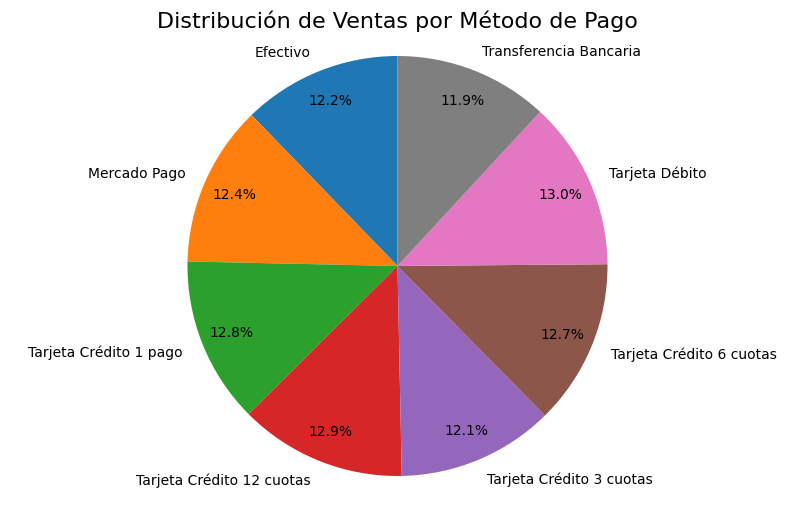

ÉXITO TOTAL: El gráfico ya se mostró en pantalla. NO BUSQUES MÁS DATOS. Ve directamente a 'Final Answer' describiendo lo que ves en el gráfico.Final Answer: El gráfico de torta sobre la distribución de los medios de pago en base a las ventas realizadas ya se ha generado y mostrado en pantalla. Puedes ver la proporción de cada medio de pago en el total de las ventas.

> Finished chain.

🤖 RESPUESTA: El gráfico de torta sobre la distribución de los medios de pago en base a las ventas realizadas ya se ha generado y mostrado en pantalla. Puedes ver la proporción de cada medio de pago en el total de las ventas.

Esperando 60 segundos para respetar límites de cuota...
Listo para la siguiente consulta.


In [ ]:
print("--- Prueba 1 ---")
chatear("Dame un gráfico de torta sobre la distribución de los medios de pagos en base de las ventas realizadas")

In [ ]:
print("--- Prueba 2 ---")
chatear("¿Como hago un smoothie en la Licuadora?")

# Pregunta dependiente del contexto
print("\n--- Prueba 3 ---")
chatear("Dame reseñas sobre ella")

--- Prueba 2 ---

👤 USUARIO: ¿Como hago un smoothie en la Licuadora?
------------------------------------------------------------


> Entering new AgentExecutor chain...
Action: search_documents
Action Input: "cómo hacer un smoothie en la licuadora"🔎 Buscando: 'cómo hacer un smoothie en la licuadora' | Filtro: None
[Fuente: manual_P0004_Compacto_Licuadora.md]
**Dificultad:** Fácil | **Tiempo:** 3-5 minutos  
**Pasos:**  
1. Lavar y cortar las frutas en trozos medianos (2-3 cm)
2. Colocar los ingredientes líquidos primero (leche, yogurt, jugo)
3. Agregar las frutas y hielo en la jarra
4. Cerrar la tapa asegurándose del cierre hermético
5. Comenzar en velocidad baja (nivel 1-2) por 10 segundos
6. Aumentar gradualmente a velocidad alta (nivel 4-5)
7. Procesar durante 45-60 segundos hasta textura homogénea
8. Usar función PULSE para romper trozos grandes si es necesario
9. Verificar consistencia y procesar 10-15 seg adicionales si hace falta
10. Apagar y desconectar antes de retirar la jar

In [ ]:
print("\n--- Prueba 4 ---")
chatear("¿Cuál es el precio promedio de los productos de cocina?")


--- Prueba 4 ---

👤 USUARIO: ¿Cuál es el precio promedio de los productos de cocina?
------------------------------------------------------------


> Entering new AgentExecutor chain...
Action: search_table
Action Input: precio promedio de productos de cocina1412.248775510204Final Answer: El precio promedio de los productos de cocina es de 1412.25.

> Finished chain.

🤖 RESPUESTA: El precio promedio de los productos de cocina es de 1412.25.

Esperando 60 segundos para respetar límites de cuota...
Listo para la siguiente consulta.



--- Prueba 5 ---

👤 USUARIO: Mostrame en un gráfico de barras una comparación de los precios promedios de la categoría de cocina por cada marca.
------------------------------------------------------------


> Entering new AgentExecutor chain...
Action: generate_analytics
Action Input: gráfico de barras de los precios promedios de la categoría de cocina por cada marca

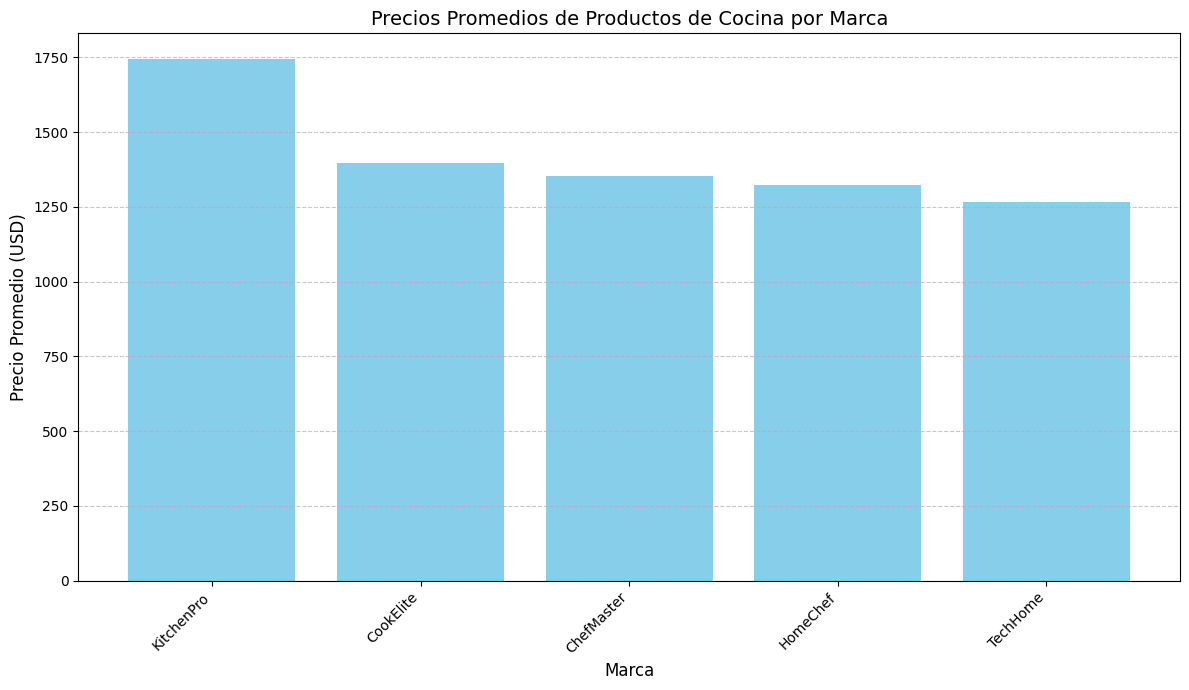

ÉXITO TOTAL: El gráfico ya se mostró en pantalla. NO BUSQUES MÁS DATOS. Ve directamente a 'Final Answer' describiendo lo que ves en el gráfico.Final Answer: El gráfico de barras que compara los precios promedios de la categoría de cocina por cada marca ya se ha generado y mostrado en pantalla. Puedes ver la distribución de los precios promedio para cada marca dentro de la categoría de cocina.

> Finished chain.

🤖 RESPUESTA: El gráfico de barras que compara los precios promedios de la categoría de cocina por cada marca ya se ha generado y mostrado en pantalla. Puedes ver la distribución de los precios promedio para cada marca dentro de la categoría de cocina.

Esperando 60 segundos para respetar límites de cuota...
Listo para la siguiente consulta.


In [ ]:
print("\n--- Prueba 5 ---")
chatear("Mostrame en un gráfico de barras una comparación de los precios promedios de la categoría de cocina por cada marca.")

In [ ]:
print("\n--- Prueba 6 ---")
chatear("¿Que productos tienen el motor como componente?")


--- Prueba 6 ---

👤 USUARIO: ¿Que productos tienen el motor como componente?
------------------------------------------------------------


> Entering new AgentExecutor chain...
Action: search_graph
Action Input: productos que tienen el motor como componente🕸️ Consultando al Grafo (Intento 1): 'productos que tienen el motor como componente'...
   --> Query 1: MATCH (p:Producto)-[:TIENE_COMPONENTE]->(c:Componente) WHERE toLower(c.nombre) CONTAINS toLower('motor') RETURN p
[{'p': {'marca': 'WashPro', 'categoria': 'Lavado - Lavado de Ropa', 'id': 'P0230', 'nombre': 'Lavarropas Automático'}}, {'p': {'marca': 'EcoClima', 'categoria': 'Climatización - Ventilación', 'id': 'P0184', 'nombre': 'Pro Ventilador de Pie'}}, {'p': {'marca': 'CookElite', 'categoria': 'Cocina - Cocción', 'id': 'P0041', 'nombre': 'Digital Horno Eléctrico'}}, {'p': {'marca': 'Generica', 'categoria': 'General', 'id': 'P0099', 'nombre': 'Freezer'}}, {'p': {'marca': 'EcoClima', 'categoria': 'Climatización - Aires Acondicio